# Homework 4 
## Predicting the Poverty of Costa Ricans

many thanks to the people and kernals I consulted. 

- https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough
- https://www.kaggle.com/youhanlee/3250feats-532-feats-using-shap-lb-0-436

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy
#import modules that describe distributions
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew
#turn off warnings for sns depreciated versions- this is the best
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
df = pd.read_csv(r"C:\Users\zgeorge\Dropbox (CMN Hospitals)\George\School\Fall 2018\Applied Machine Learning\AML_code\Homework 4\Data\train.csv")
ID = df['Id']
Target = df['Target']
df.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


## Cleaning Data
### Correct Data Types

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [4]:
#fix the variables that should be categorical
df[['dependency','edjefa','edjefe',]] = df[['dependency','edjefa','edjefe',]].astype('category')
#fix the variables that should be Bool
#df[['']] = df[['']].astype('bool')
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: category(3), float64(8), int64(130), object(2)
memory usage: 10.2+ MB


### Removing Nulls

In [5]:
#because when categorical data has n/a's in many cases that is just another category. However the numerical should not have n/a's
numeric_train=df.select_dtypes(include=[np.number])
#create NA's count variable
nas = numeric_train.isnull().sum().sort_values(ascending=False)
#create percent variable
percent = 100*(numeric_train.isnull().sum()/numeric_train.isnull().count()).sort_values(ascending=False)
#combine lists
nasnum_train = pd.concat([nas, percent],axis=1,keys=['NAs','Percent'])
nasnum_train.head(5)

,NAs,Percent
rez_esc,7928,82.954902
v18q1,7342,76.823271
v2a1,6860,71.779847
meaneduc,5,0.052318
SQBmeaned,5,0.052318


In [6]:
#dropping rez_esc for now, hopefully we can come back to reclaim this variable
df = df.drop(['rez_esc'],axis=1)

In [7]:
#v18q1 is the number of tablets, fill in with zeros
df['v18q1'] = df['v18q1'].fillna(0)

In [8]:
#give them the median education for their age for mean educ
df['meaneduc'] = df.apply(
    lambda row: row['edjefe'] if np.isnan(row['meaneduc']) else row['meaneduc'],
    axis=1
)

In [9]:
df['meaneduc'] = df.apply(
    lambda row: row['edjefa'] if row['meaneduc']=='no' else row['meaneduc'],
    axis=1
)
df[['meaneduc']] = df[['meaneduc']].astype('int32')
df['SQBmeaned'] = df['meaneduc']**2

In [10]:
#for v2a1, because there are so few people renting, we will drop that for now BUT COME BACK TO THIS
df = df.drop('v2a1',axis=1)

In [11]:
def replace_edjefx(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x
df['edjefe'] = df['edjefe'].apply(replace_edjefx).astype(float)
df['edjefa'] = df['edjefa'].apply(replace_edjefx).astype(float)

### Checking for covariance

In [12]:
#Create a list that displays only numeric variables
numeric_var=df.select_dtypes(include=[np.number]).columns
#Here we set up our correlation matrix for numeric variables
correlation=df[numeric_var].corr()
#Pull the max (whether positive or negative) correlation of each variable to another variable
aux=(abs(correlation)-np.identity(correlation.shape[0])).max()
aux.sort_index

<bound method Series.sort_index of hacdor             0.794699
rooms              0.804070
hacapo             0.652594
v14a               0.532663
refrig             0.223078
v18q               0.849916
v18q1              0.849916
r4h1               0.758136
r4h2               0.821367
r4h3               0.821367
r4m1               0.767461
r4m2               0.820109
r4m3               0.820109
r4t1               0.782178
r4t2               0.806381
r4t3               0.998107
tamhog             1.000000
tamviv             0.945243
escolari           0.943325
hhsize             1.000000
paredblolad        0.582085
paredzocalo        0.351198
paredpreb          0.582085
pareddes           0.434230
paredmad           0.451195
paredzinc          0.303911
paredfibras        0.252625
paredother         0.173487
pisomoscer         0.804205
pisocemento        0.804205
                     ...   
bedrooms           0.804070
overcrowding       0.945094
tipovivi1          0.599882
tipovivi2    

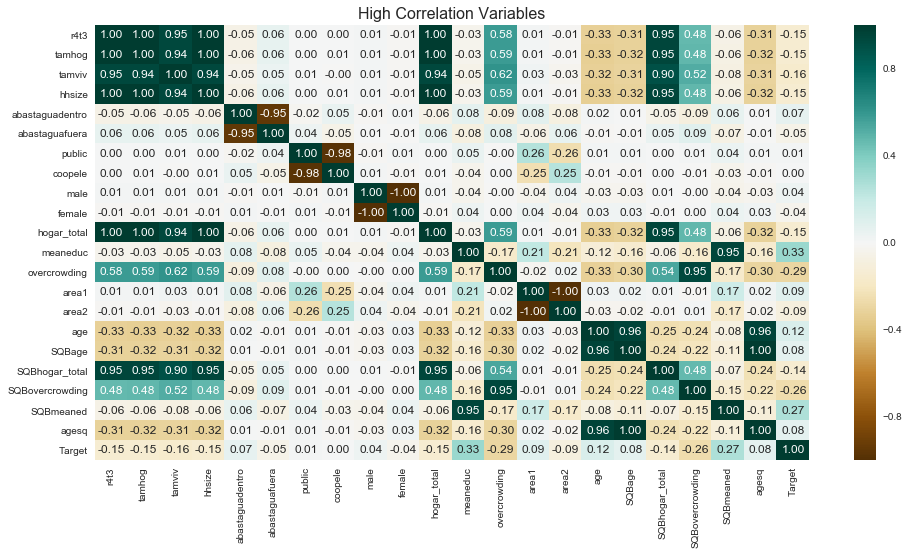

In [13]:
#Throw out any variables that don't have at least .7 correlation with something else
selected_feats=aux[(aux>0.945) | ((aux>.328198) & (aux<.3282))].index
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
#make the plot have numbers, a legend and pretty colors
sns.heatmap(correlation.loc[selected_feats,selected_feats], annot=True,fmt='.2f',ax=ax,cmap="BrBG",center=0)
plt.title('High Correlation Variables',fontsize=16)
#show the plot
plt.show()

Covariates:
 - r4t3 & tamhog & hhsize & hogar_total: keep hhsize for sake of var name
 - public and coopele: keeping public as there is a slight correlation
 - area1 & area2: getting rid of area 2 as you have to be one or the other
 - male & female: getting rid of female
 - abastaguadentro & abastaguafuera: whether there is a water provision on the inside or outside of the dwelling. As there is a third option of no water, we will leave these for now.
 
Squared Variables:
 - SQBescolari & escolari: Keep escolari
 - SQBage & agesq & age: Keep age
 - hhtotal & SQBhogar_total: keep hhtotal
 - SQBovercrowding & overcrowding: Keep overcrowding
 - SQBmeaned & meaned: Keep meaned
 (add teh other squared variables)

In [14]:
df = df.drop(['r4t3','tamhog','hogar_total','coopele','area2','female'],axis=1)
df = df.drop(['SQBescolari','SQBage','agesq','SQBhogar_total','SQBovercrowding','SQBmeaned'],axis=1)
#df = df.drop(['SQBedjefe','SQBhogar_nin'],axis=1)
#dropping dependency for time's sake. fix this
df = df.drop('dependency',axis=1)

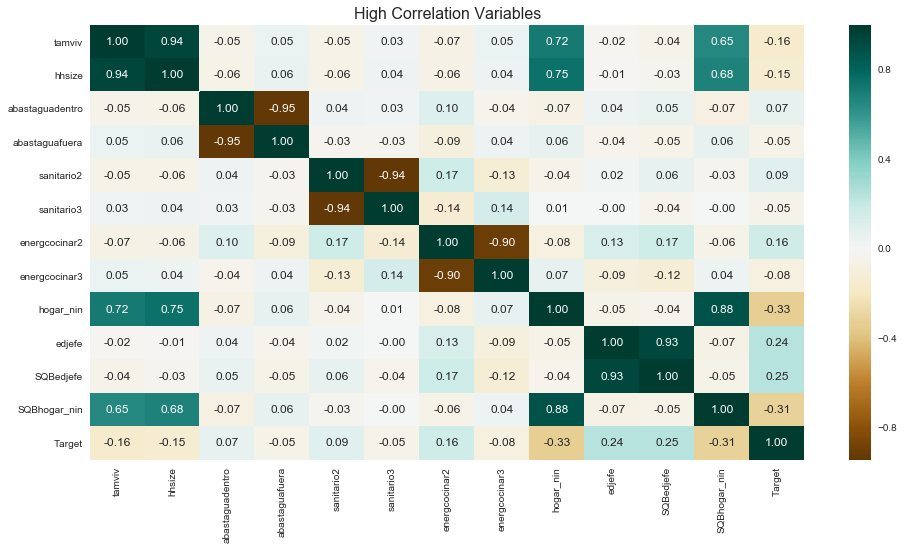

In [15]:
#Create a list that displays only numeric variables
numeric_var=df.select_dtypes(include=[np.number]).columns
#Here we set up our correlation matrix for numeric variables
correlation=df[numeric_var].corr()
#Pull the max (whether positive or negative) correlation of each variable to another variable
aux=(abs(correlation)-np.identity(correlation.shape[0])).max()#Throw out any variables that don't have at least .7 correlation with something else
selected_feats=aux[(aux>0.85) | ((aux>.328198) & (aux<.3282))].index
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
#make the plot have numbers, a legend and pretty colors
sns.heatmap(correlation.loc[selected_feats,selected_feats], annot=True,fmt='.2f',ax=ax,cmap="BrBG",center=0)
plt.title('High Correlation Variables',fontsize=16)
#show the plot
plt.show()

In [16]:
df.shape

(9557, 128)

### Feature Engineering

### Setting up your Model

https://www.analyticsindiamag.com/7-types-classification-algorithms/

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, KFold
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [18]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [19]:
scores_forrest = []
scores_knearest = []

In [20]:
Id = df['Id']
IdHogar = df['idhogar']
train_y = pd.DataFrame()
train_x = pd.DataFrame()
train_y['Target'] = df['Target']
train_x = df.drop(['Target','Id','idhogar'],axis=1)

In [21]:
scaler = StandardScaler()
scaler.fit(train_x)
scaled_df = scaler.transform(train_x)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.33, random_state=42)
F1_scorer = make_scorer(f1_score, greater_is_better=True, average='macro')

### Gaussian Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB
#priors=estimator.get_params().keys()
gnb = GaussianNB()#priors=priors)
#gnb_pred = gnb()
#param_grid = {"n_neighbors": [3, 5, 7],
#             "weights": ['uniform','distance'],
#              "p": [1,2]}
gnb.fit(X_train,y_train)
#gnb_gridsearch = (n_splits=5,gnb,cv=3,scoring=F1_scorer)

GaussianNB(priors=None)

In [24]:
print("Test Accuracy: {}".format(accuracy_score(y_test, gnb.predict(X_test))))
print("F1 Score: {}".format(f1_score(y_test, gnb.predict(X_test),average='macro')))

Test Accuracy: 0.4064679771718453
F1 Score: 0.32084003666476524


Confusion matrix, without normalization
[[  99    4  146   15]
 [ 109   27  365   23]
 [  54    3  320   45]
 [  90   15 1003  836]]


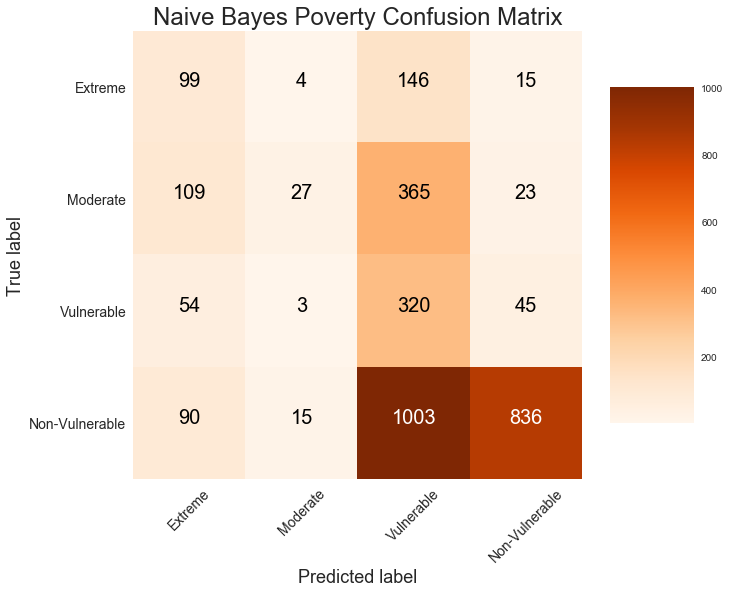

In [25]:
gnb_cm = confusion_matrix(y_test, gnb.predict(X_test))
plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Naive Bayes Poverty Confusion Matrix')
plt.show()

### K-Nearest Neighbors

In [26]:
from sklearn.neighbors import KNeighborsClassifier
knk = KNeighborsClassifier(n_jobs = -1)

param_grid = {"n_neighbors": [3, 5, 7],
             "weights": ['uniform','distance'],
              "p": [1,2]}

knk_gridsearch = GridSearchCV(knk,param_grid=param_grid,scoring='accuracy',cv=3)

knk_gridsearch.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [27]:
print("Best Params: {}".format(knk_gridsearch.best_params_))
print("Test Accuracy: {}".format(accuracy_score(y_test, knk_gridsearch.predict(X_test))))
print("F1 Score: {}".format(f1_score(y_test, knk_gridsearch.predict(X_test),average='macro')))

Best Params: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Test Accuracy: 0.7920101458465441
F1 Score: 0.6939584161342349


Confusion matrix, without normalization
[[ 160   26   10   68]
 [  23  322   49  130]
 [  16   40  224  142]
 [  29   63   60 1792]]


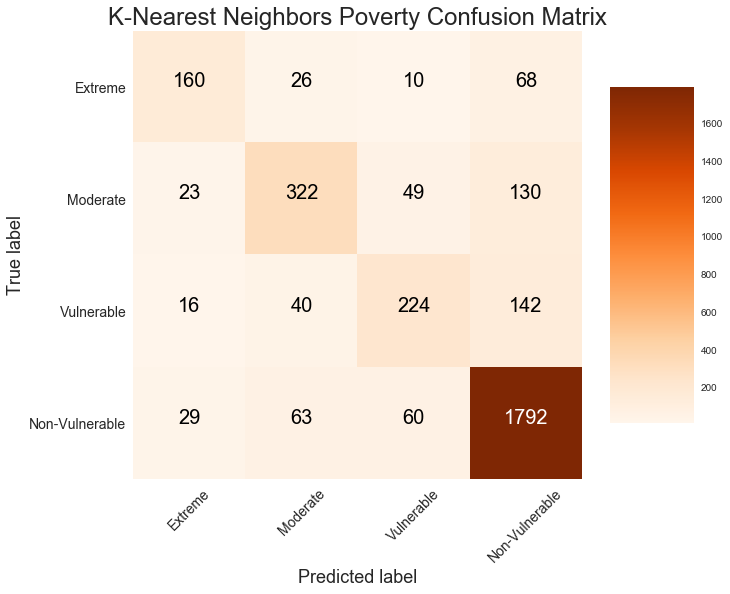

In [28]:
cm = confusion_matrix(y_test, knk_gridsearch.predict(X_test))

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'K-Nearest Neighbors Poverty Confusion Matrix')
plt.show()

### Random Forest Classifier

In [29]:
rfc = RandomForestClassifier(random_state=42, n_jobs = -1)

param_grid = {"n_estimators": [90, 105, 110, 120, 140],
             "max_features": ['auto','log2']}

rfc_gridsearch = GridSearchCV(rfc,param_grid=param_grid,scoring=F1_scorer,cv=5)

rfc_gridsearch.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [90, 105, 110, 120, 140], 'max_features': ['auto', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, average=macro), verbose=0)

In [30]:
print("Best Params: {}".format(rfc_gridsearch.best_params_))
print("Test Accuracy: {}".format(accuracy_score(y_test, rfc_gridsearch.predict(X_test))))
print("F1 Score: {}".format(f1_score(y_test, rfc_gridsearch.predict(X_test),average='macro')))


Best Params: {'max_features': 'auto', 'n_estimators': 120}
Test Accuracy: 0.9096385542168675
F1 Score: 0.8723422456569466


Confusion matrix, without normalization
[[ 212   15    0   37]
 [  10  431   11   72]
 [   0   18  303  101]
 [   3   13    5 1923]]


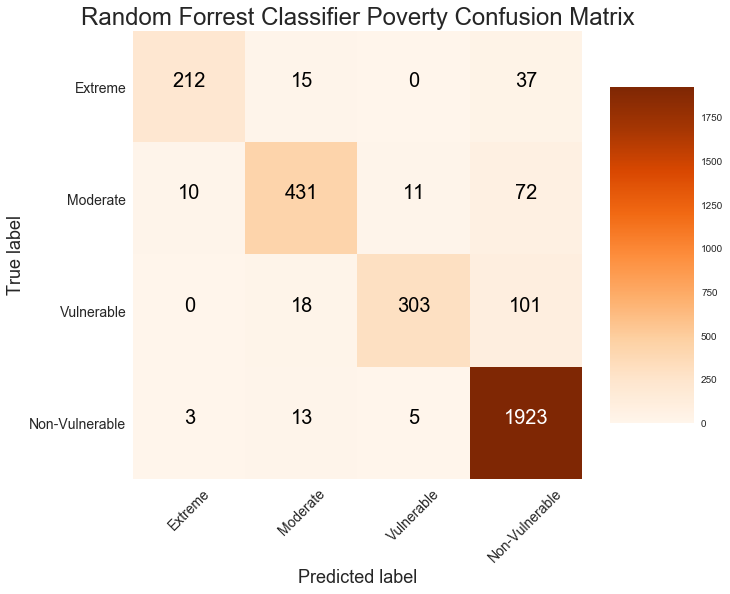

In [31]:
cm = confusion_matrix(y_test, rfc_gridsearch.predict(X_test))

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Random Forrest Classifier Poverty Confusion Matrix')
plt.show()

In [32]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(penalty='l1')

param_grid = {"loss": ['hinge', 'log', 'modified_huber',
    'squared_hinge', 'perceptron'],
             "l1_ratio" :[.55,.56,.57,.58,.59,.6]}

sgd_gridsearch = GridSearchCV(sgd,param_grid=param_grid,scoring=F1_scorer,cv=5)

sgd_gridsearch.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 'l1_ratio': [0.55, 0.56, 0.57, 0.58, 0.59, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, average=macro), verbose=0)

In [33]:
print("Best Params: {}".format(sgd_gridsearch.best_params_))
print("Test Accuracy: {}".format(accuracy_score(y_test, sgd_gridsearch.predict(X_test))))
print("F1 Score: {}".format(f1_score(y_test, sgd_gridsearch.predict(X_test),average='macro')))

Best Params: {'l1_ratio': 0.56, 'loss': 'squared_hinge'}
Test Accuracy: 0.5317057704502219
F1 Score: 0.29698263701980765


Confusion matrix, without normalization
[[   6   41  170   47]
 [   7   33  347  137]
 [   7    8  242  165]
 [   8   14  526 1396]]


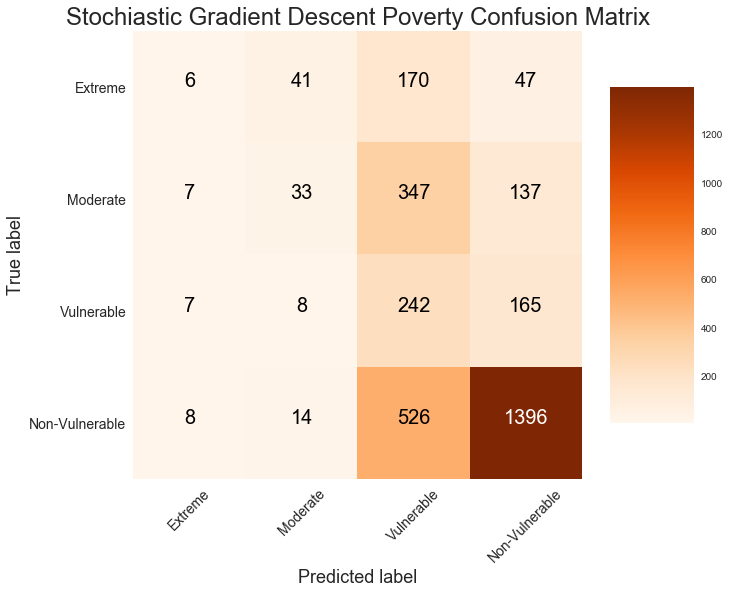

In [34]:
cm = confusion_matrix(y_test, sgd_gridsearch.predict(X_test))

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Stochiastic Gradient Descent Poverty Confusion Matrix')
plt.show()

In [37]:
svm = SVC()

param_grid = {"C": [8,9,10],"decision_function_shape": ['ovo', 'ovr']}

svm_gridsearch = GridSearchCV(svm,param_grid=param_grid,scoring=F1_scorer,cv=3,verbose=3,n_jobs = -1)

svm_gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [8, 9, 10], 'decision_function_shape': ['ovo', 'ovr']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, average=macro), verbose=3)

In [38]:
print("Best Params: {}".format(svm_gridsearch.best_params_))
print("Test Accuracy: {}".format(accuracy_score(y_test, svm_gridsearch.predict(X_test))))
print("F1 Score: {}".format(f1_score(y_test, svm_gridsearch.predict(X_test),average='macro')))

Best Params: {'C': 9, 'decision_function_shape': 'ovo'}
Test Accuracy: 0.7295497780596069
F1 Score: 0.5902906516009678


Confusion matrix, without normalization
[[ 123   43   20   78]
 [  35  262   48  179]
 [  22   42  164  194]
 [  32  104   56 1752]]


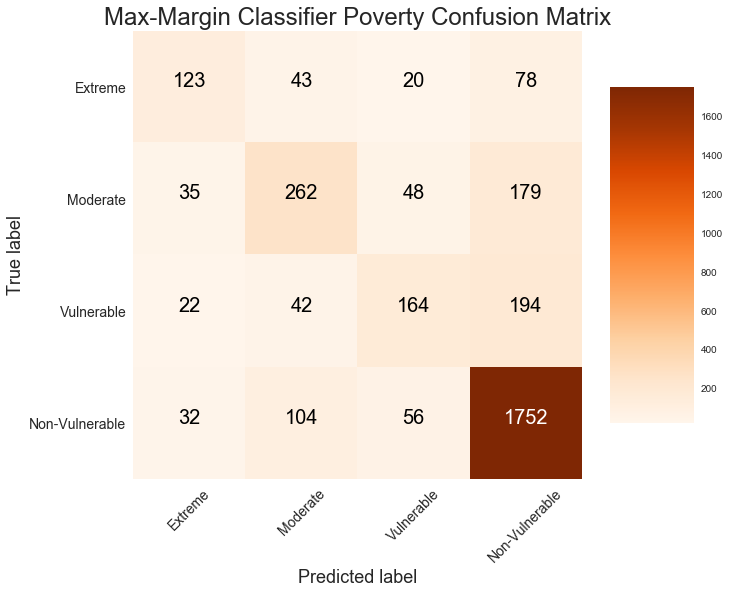

In [43]:
cm = confusion_matrix(y_test, svm_gridsearch.predict(X_test))

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Max-Margin Classifier Poverty Confusion Matrix')
plt.show()

In [44]:
print("Test Accuracy: {}".format(accuracy_score(y_test, gnb.predict(X_test))))
print("F1 Score: {}".format(f1_score(y_test, gnb.predict(X_test),average='macro')))
print("**********************************************************************************")
print("Best Params: {}".format(knk_gridsearch.best_params_))
print("Test Accuracy: {}".format(accuracy_score(y_test, knk_gridsearch.predict(X_test))))
print("F1 Score: {}".format(f1_score(y_test, knk_gridsearch.predict(X_test),average='macro')))
print("**********************************************************************************")
print("Best Params: {}".format(rfc_gridsearch.best_params_))
print("Test Accuracy: {}".format(accuracy_score(y_test, rfc_gridsearch.predict(X_test))))
print("F1 Score: {}".format(f1_score(y_test, rfc_gridsearch.predict(X_test),average='macro')))
print("**********************************************************************************")
print("Best Params: {}".format(sgd_gridsearch.best_params_))
print("Test Accuracy: {}".format(accuracy_score(y_test, sgd_gridsearch.predict(X_test))))
print("F1 Score: {}".format(f1_score(y_test, sgd_gridsearch.predict(X_test),average='macro')))
print("**********************************************************************************")
print("Best Params: {}".format(svm_gridsearch.best_params_))
print("Test Accuracy: {}".format(accuracy_score(y_test, svm_gridsearch.predict(X_test))))
print("F1 Score: {}".format(f1_score(y_test, svm_gridsearch.predict(X_test),average='macro')))

Test Accuracy: 0.4064679771718453
F1 Score: 0.32084003666476524
**********************************************************************************
Best Params: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Test Accuracy: 0.7920101458465441
F1 Score: 0.6939584161342349
**********************************************************************************
Best Params: {'max_features': 'auto', 'n_estimators': 120}
Test Accuracy: 0.9096385542168675
F1 Score: 0.8723422456569466
**********************************************************************************
Best Params: {'l1_ratio': 0.56, 'loss': 'squared_hinge'}
Test Accuracy: 0.5317057704502219
F1 Score: 0.29698263701980765
**********************************************************************************
Best Params: {'C': 9, 'decision_function_shape': 'ovo'}
Test Accuracy: 0.7295497780596069
F1 Score: 0.5902906516009678


## Checking Our Models for Efficacy

In [47]:
models = []
models.append(['gnb', GaussianNB()])
models.append(['knn', KNeighborsClassifier(n_neighbors= 3, p= 1, weights= 'distance')])
models.append(['rfc', RandomForestClassifier(max_features= 'auto', n_estimators= 120)])
models.append(['sgd', SGDClassifier(l1_ratio= 0.56, loss= 'squared_hinge')])
models.append(['svm', SVC(C=9,decision_function_shape='ovo')])
# evaluate each model in turn
results = []
names = []

In [48]:
for name, model in models:
    kfold = KFold(n_splits=15, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=F1_scorer)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

gnb: 0.303731 (0.024141)
knn: 0.668958 (0.025611)
rfc: 0.851839 (0.024064)
sgd: 0.345899 (0.038421)
svm: 0.577758 (0.027682)


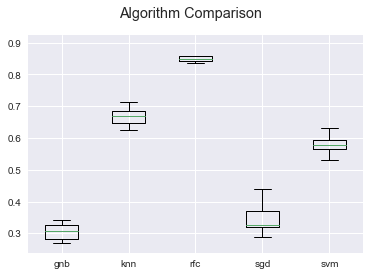

In [49]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [51]:
gnb_cm = confusion_matrix(y_test, gnb.predict(X_test))
knk_cm = confusion_matrix(y_test, knk_gridsearch.predict(X_test))
rfc_cm = confusion_matrix(y_test, rfc_gridsearch.predict(X_test))
sgd_cm = confusion_matrix(y_test, sgd_gridsearch.predict(X_test))
svm_cm = confusion_matrix(y_test, svm_gridsearch.predict(X_test))